In [77]:
import pandas as pd
import numpy as np
from nltk.tokenize import MWETokenizer
import re
import nltk
import seaborn as sns


import matplotlib.pyplot as plt

def explode_list(df, col):
    s = df[col]
    i = np.arange(len(s)).repeat(s.str.len())
    return df.iloc[i].assign(**{col: np.concatenate(s)})


def tokenize(text):
        a = re.sub(r'[^\w\s]','', text)
        a = mwe.tokenize(a.lower().split())
        tokens_with_keywords = [word for word in a if word in keyword['mwe'].tolist()]
        return tokens_with_keywords

#get the keyword, put it in the dataframe with keyword, mwe (Multi-Word Expression Tokenizer ntlk)
url = 'https://raw.githubusercontent.com/zahradaniar/summer2021internship/master/City%20Of%20Boston/portuguese_keywords_and_categories.csv'
keyword = pd.read_csv(url, header=None)
keyword.columns = ['categories','keyword']
keyword['mwe'] = keyword['keyword'].str.replace(' ','_')
keyword['mwe'] = keyword['mwe'].str.lower()

#build the MWE tokenizer
mwe = MWETokenizer()
for index, row in keyword.iterrows():
    mwe.add_mwe(row['keyword'].split())

#get the articles
url = 'https://raw.githubusercontent.com/BU-Spark/summer2021internship/master/City%20Of%20Boston/data/BrazilianTimes_Jan2020_to_Jun2021.csv'
df = pd.read_csv(url, index_col=[0])

#combine the Title and Article
df["Article"] = df["Title"] + df["Article"]
df = df.dropna(subset=['Article'])
df['tokenized_text'] = df.apply(lambda row: tokenize(row['Article']) , axis=1)

#now we done with Article, drop everything but tokenized text
df= df.drop(['URL', 'Title', 'Article'], axis = 1)
df = explode_list(df, 'tokenized_text')

#replace index from the Date into real index
df.reset_index(inplace=True)

#change the Date column from string type to DateTime
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%M-%d')

#put the week and the year 
df['Year/Week'] = df['Date'].apply(lambda x: "%d-%d" % (x.year, x.week))
pd.set_option('display.max_rows', df.shape[0]+1)
df.groupby(['Year/Week', 'tokenized_text']).size()
cat_df = pd.merge(df, keyword,  how="left", left_on='tokenized_text', right_on='mwe')
final = cat_df.groupby(['Year/Week', 'categories']).size().to_frame('occurrences')
print(final)


                                       occurrences
Year/Week categories                              
2020-1    Covid-19 Related                     632
          Covid-19 Symptoms                     17
          Economic Recovery                     43
          Retail                                72
          Travel & Outdoor Activities          128
2020-2    Covid-19 Related                    1001
          Covid-19 Symptoms                     35
          Economic Recovery                     68
          Retail                                85
          Travel & Outdoor Activities          170
2020-3    Covid-19 Related                     899
          Covid-19 Symptoms                     37
          Economic Recovery                     90
          Retail                                74
          Travel & Outdoor Activities          191
2020-4    Covid-19 Related                     993
          Covid-19 Symptoms                     32
          Economic Recovery    

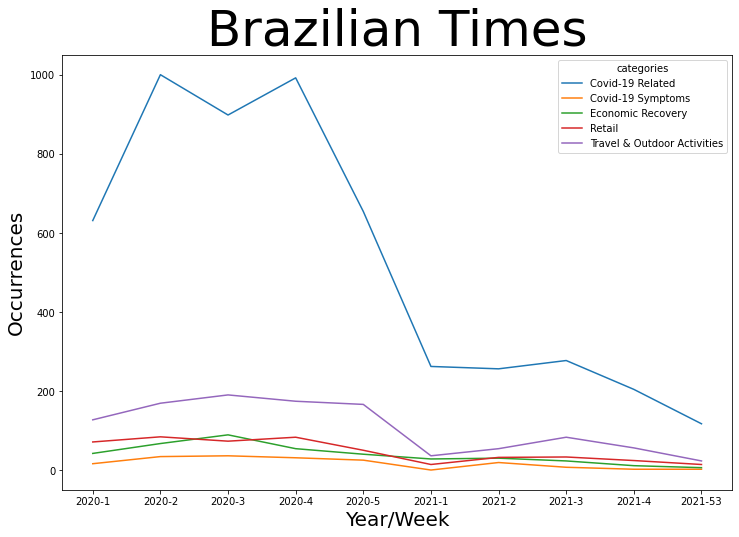

In [78]:
plt.figure(figsize=(12,8))
b=sns.lineplot(data=final, x="Year/Week", y="occurrences", hue="categories")
b.axes.set_title("Brazilian Times",fontsize=50)
b.set_xlabel("Year/Week",fontsize=20)
b.set_ylabel("Occurrences",fontsize=20)
b.tick_params(labelsize=10)
